<a href="https://colab.research.google.com/github/COGS-Programming-Club/MachineLearning/blob/main/IntroToPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction to Deep Learning with PyTorch**

by Juan C. Reyes

Geospatial Data Analytics 2022

Import necessary PyTorch for working with neural networks.

Import numpy for performing mathematical operations.

Import matplotlib for producing graphs. 

In [1]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision for loading MNIST dataset
import torchvision
from torchvision import datasets, transforms

# For Mathematical Operations
import numpy as np

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib inline sets the backend of matplotlib to the 'inline' backend: 
# With this backend, the output of plotting commands is displayed inline within frontends like the 
# Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots will then also be stored in the notebook document.

Google Colab comes "pre-loaded" with MNIST data.
We can download the training and testing data directly into this notebook. The images are stored as a PIL image and must be transformed into a tensor in order to be fed into the neural network.

https://en.wikipedia.org/wiki/MNIST_database

torchvision.transforms documentation : https://pytorch.org/vision/stable/transforms.html

ToTensor: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

Normalize: Normalize a float tensor image with mean and standard deviation. This transform does not support PIL Image.

Why do we normalize the images?
*Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the sttdev of that feature or pixel as well if you want to normalize each feature value to a z-score.*

https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current



In [2]:
# Download the training data
# Set the train parameter to "True" to download the training set.
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

# Number classes, integers from 0-9.
classes = [i for i in range(10)]

# Print the number of training / testing sets
print("Training examples: ", len(train_data))
print("Test examples: ", len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Training examples:  60000
Test examples:  10000


Define a function to take an image, convert it into a numpy image and use matplotlib to display the image.

*Both in Pytorch and Tensorflow, the .numpy() method is pretty much straightforward. It converts a tensor object into an numpy.ndarray object. This implicitly means that the converted tensor will be now processed on the CPU.*
https://stackoverflow.com/questions/63968868/what-does-the-numpy-function-do

In [3]:
# function to show an image
def imshow(img):
    img = 1*img / 2 + 0.5 # unnormalize for the purpose of visualizing the img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(img) #why do we need to transpose? what happens if we dont?


Data loader and iter:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

*PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.*

In [4]:
sample_picture = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
print(type(sample_picture))


<class 'torch.utils.data.dataloader.DataLoader'>


*We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=5 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).*

https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
torch.Size([5, 1, 28, 28])
      3       1       2       1       8


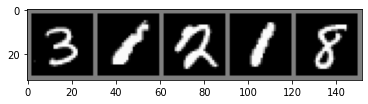

In [5]:
# Create an iterable dataiter, which then is iterated through by the .next() function.
dataiter = iter(sample_picture)
print(type(dataiter))
images, labels = dataiter.next()

# Display the size of the images
print(images.size())
# show images in a grid
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%7s' % classes[labels[j]] for j in range(images.shape[0])))

Now that our data has been loaded, we can proceed to implement a neural network which will take the tensor image data, and train the neural network classifier.

In [6]:
def eval_net_d(epochs, batch_size):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size
  #optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999),eps=1e-08,) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      
      optimizer.zero_grad() # zero the parameter gradients
      outputs = net(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update
      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc, net

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8766833333333334
Test accuracy:  0.8849


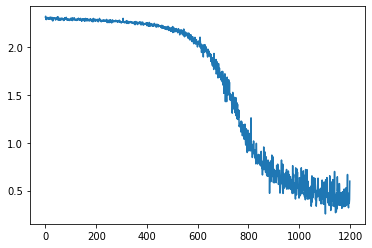

In [7]:
# We will call your answer like this:
losses, train_acc, test_acc,thenet = eval_net_d(epochs=2, batch_size=100)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
plt.plot(losses)
plt.show()

GroundTruth:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9
Predicted:    7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 2 0 4 1 9 5 7 8 4 2 7 4 2 4 3 0 7 0 2 8 1 7 3 7 9 7 7 6 2 7 8 4 7 5 6 1 3 6 9 3 1 4 1 9 6 9


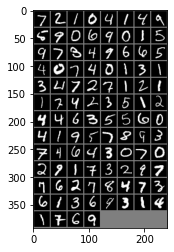

In [8]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%1s' % classes[labels[j]] for j in range(images.shape[0])))

outputs = thenet(images)

_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%1s' % classes[predicted[j]]
                              for j in range(predicted.shape[0])))